# Tobigs 21기 4주차 정규세션 Ensemble

### 앙상블 모델 최소 2가지를 이용해 코드를 짜주세요!
- 전처리와 모델 성능결과 출력 모두 진행해주세요.
- 데이터셋: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers
    - 다른 데이터셋을 사용해도 괜찮습니다! 대신 출처를 명시해주세요.

## Import


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/ToBigs/04. Ensemble/과제/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


해당 데이터는 Attrition Flag '퇴직 1/0'을 예측하는 데이터 세트.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

Feature 21 & 22의 경우 데이터 셋에서 삭제하는 것을 추천하는 문구 발견, 삭제

In [5]:
df.drop(df.columns[[21, 22]], axis = 1, inplace = True) # inplace = True 데이터 원본에서 처리 not copy
df.columns # dropped

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

## EDA

결측치 및 중복 값 확인

In [6]:
print(df.isna().sum())
print("duplicates :", df.duplicated().sum())

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64
duplicates : 0


  - 둘 다 문제 없음으로 별도의 처리 불필요

Category, Numerical values 각각 확인

In [7]:
## cat
cat_col = df.select_dtypes('object').columns.tolist()
for each_col in cat_col:
  target = df[each_col]
  print("==========")
  print(each_col)
  print(target.nunique())
  print(target.value_counts())

Attrition_Flag
2
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
Gender
2
F    5358
M    4769
Name: Gender, dtype: int64
Education_Level
7
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
Marital_Status
4
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64
Income_Category
6
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64
Card_Category
4
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64


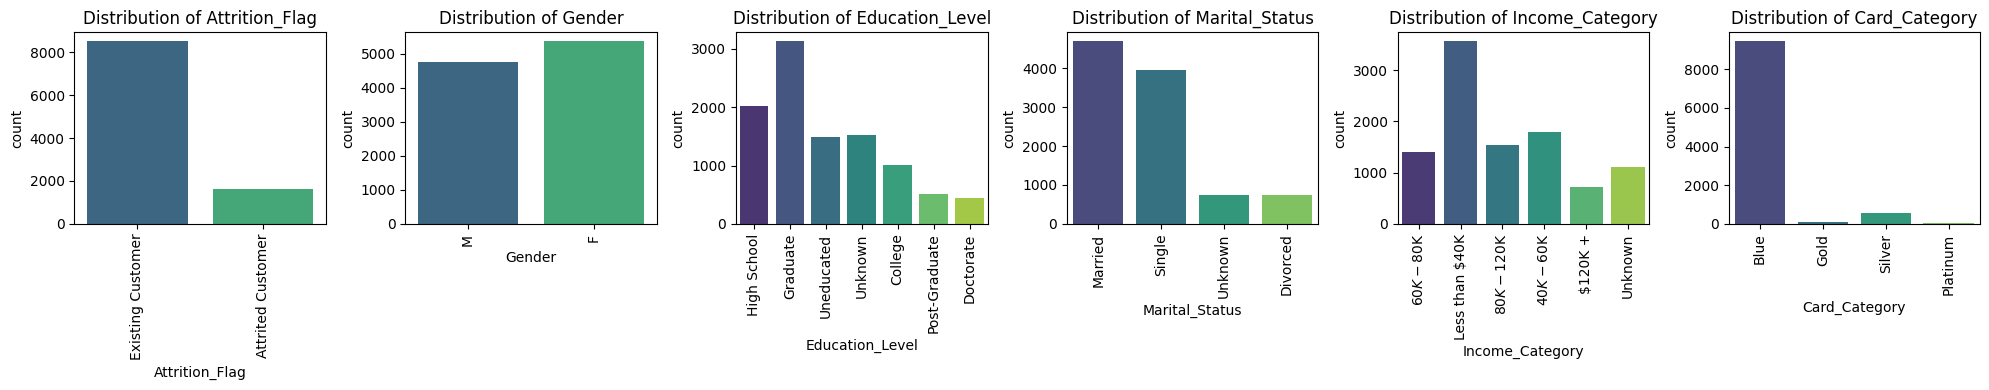

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=len(cat_col), figsize=(20, 4))

for ax, category in zip(axes, cat_col):
    sns.countplot(x=category, data=df, ax=ax, hue=category, palette='viridis', legend=False)  # Assign x to hue
    ax.set_title(f'Distribution of {category}')
    ax.tick_params(axis='x', rotation=90)  # Rotate labels to prevent overlap
    #ax.get_legend().remove()  # Remove the legend to clean up each plot

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()


- Target : Attrition Flag가 imbalanced된 것 확인.
- Gender : 여성이 살짝 더 많다.
- Education Level : Graduate값이 가장 많다. 대학교/고등학교 졸업인지 미확인.
- Maritial Status : Married > Single > Divorced > Unknown 순.
- Income Category : Less than $40K가 가장 많고 $120K + 가 가장 적다.
- Distribution of Card_category : Blue > Silver > Gold > Premium순으로 많다. 아마 연회비도 동일 순으로 들어가지 않을까 싶다.

In [9]:
## num
num_col = df.select_dtypes(exclude= object).columns.tolist()
for each_col in num_col:
  print(f"============ {each_col} =============")
  each_unique = df[each_col]
  if df[each_col].nunique() < 30:
    print(df[each_col].value_counts())
  else:
    #print("too many unique values")
    print("total unique num count:", df[each_col].nunique())

============ CLIENTNUM =============
total unique num count: 10127
============ Customer_Age =============
total unique num count: 45
============ Dependent_count =============
3    2732
2    2655
1    1838
4    1574
0     904
5     424
Name: Dependent_count, dtype: int64
============ Months_on_book =============
total unique num count: 44
============ Total_Relationship_Count =============
3    2305
4    1912
5    1891
6    1866
2    1243
1     910
Name: Total_Relationship_Count, dtype: int64
============ Months_Inactive_12_mon =============
3    3846
2    3282
1    2233
4     435
5     178
6     124
0      29
Name: Months_Inactive_12_mon, dtype: int64
============ Contacts_Count_12_mon =============
3    3380
2    3227
1    1499
4    1392
0     399
5     176
6      54
Name: Contacts_Count_12_mon, dtype: int64
============ Credit_Limit =============
total unique num count: 6205
============ Total_Revolving_Bal =============
total unique num count: 1974
============ Avg_Open_To_Buy ===

Client num 모두 다른 수치임으로 삭제


In [10]:
print("Before drop:", len(df.columns))
df.drop('CLIENTNUM', axis=1, inplace = True)
num_col.remove('CLIENTNUM')
print("After drop:", len(df.columns))

Before drop: 21
After drop: 20


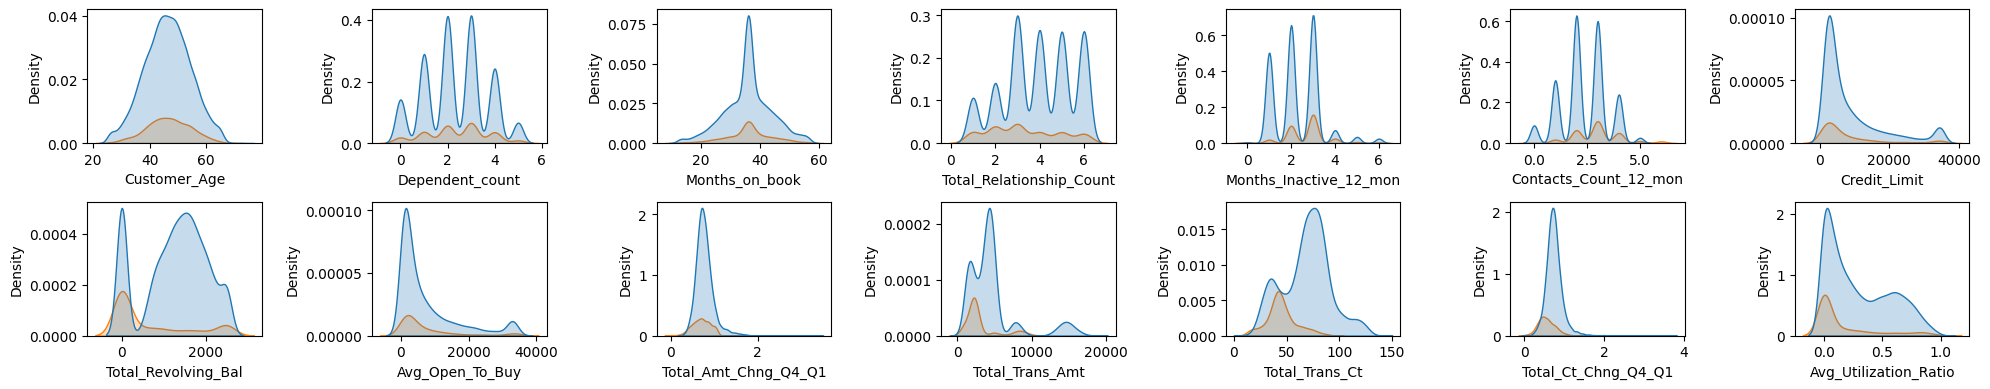

In [11]:
fig, ax = plt.subplots(2, 7, figsize=(20, 4))
num_col_index = 0  # Attrion_flag 건너뛰기 용

for i, col in enumerate(num_col):
    if col == 'Attrition_Flag':
        continue
    else:
        row_index = num_col_index // 7
        col_index = num_col_index % 7
        sns.kdeplot(data=df, x=col, fill=True, ax=ax[row_index, col_index], hue=df['Attrition_Flag'], legend=False)
        num_col_index += 1  # Only increment for columns that are plotted

plt.tight_layout()
plt.show()


Category -> Label encoder, Numerical -> Min Max Scaling 적용

In [12]:
# cat_col
for each_col in cat_col:
  label = LabelEncoder().fit(df[each_col])
  df[each_col] = label.transform(df[each_col])

# num_col
mm = MinMaxScaler().fit(df[num_col])
df[num_col] = mm.transform(df[num_col])

# checking the target value
print(df['Attrition_Flag'].value_counts()) # Attrition(퇴직) 이 했을때 1인 것이 해석하기 용이할 것 같아서 둘이 뒤바꿈
df['Attrition_Flag'] = 1 - df['Attrition_Flag']
print(df['Attrition_Flag'].value_counts()) # 수정 확인

1    8500
0    1627
Name: Attrition_Flag, dtype: int64
0    8500
1    1627
Name: Attrition_Flag, dtype: int64


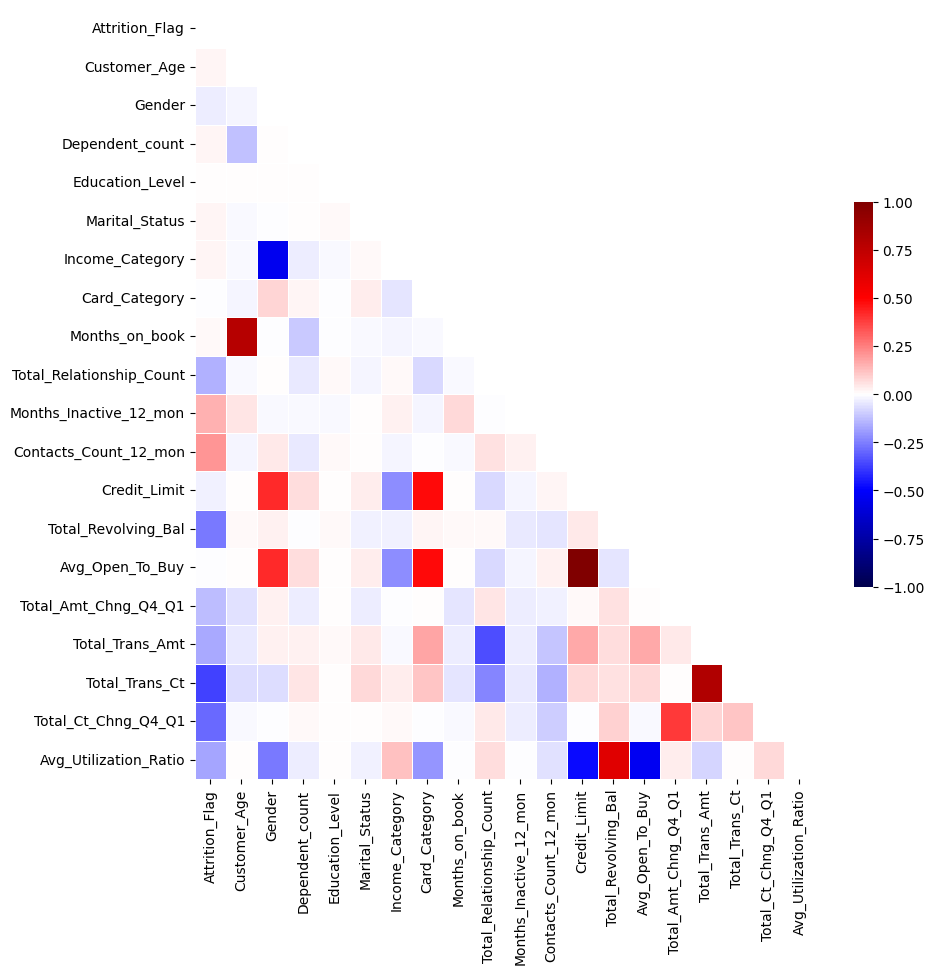

In [13]:
df_corr = df.corr()

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(10,10) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr, dtype= bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df_corr,
            cmap = 'seismic',
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )
plt.show()

Avg_Open_To_Buy와 Credit_Limit correlation 값이 1인 것으로 확인, scatter plot 확인

Correlation between Avg_Open_To_Buy and Credit_Limit: 0.9959805439320064


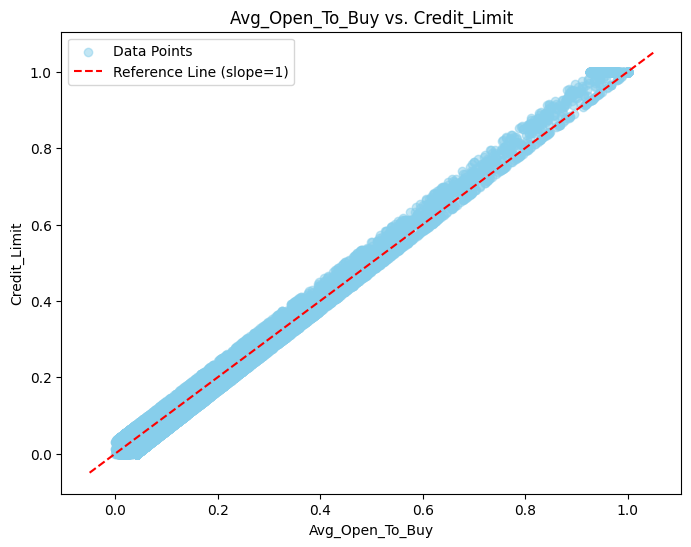

In [14]:
correlation = df[['Avg_Open_To_Buy', 'Credit_Limit']].corr().iloc[0, 1]
print(f"Correlation between Avg_Open_To_Buy and Credit_Limit: {correlation}")

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(df['Avg_Open_To_Buy'], df['Credit_Limit'], alpha=0.5, label='Data Points', color = "skyblue")

x_vals = np.array(plt.gca().get_xlim())
y_vals = x_vals  # 1
plt.plot(x_vals, y_vals, '--', color="red", label='Reference Line (slope=1)')

plt.title('Avg_Open_To_Buy vs. Credit_Limit')
plt.xlabel('Avg_Open_To_Buy')
plt.ylabel('Credit_Limit')
plt.legend()
plt.show()

- Credit limit 이 Avg_open_to_Buy 보다 가지수가 적어 삭제

In [15]:
print("Before drop:", len(df.columns))
df.drop('Credit_Limit', axis=1, inplace = True)
num_col.remove('Credit_Limit')
print("After drop:", len(df.columns))

Before drop: 20
After drop: 19


## Modeling

Train_test Split

In [18]:
#train_test_split
X = df.drop('Attrition_Flag', axis =1)
y = df['Attrition_Flag']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape


((7088, 18), (3039, 18), (7088,), (3039,))

In [21]:
# 데이터 불균형 처리 위해 parameter 설정
rf_clf = RandomForestClassifier(class_weight='balanced')
xgb_clf = XGBClassifier(scale_pos_weight=sum(y == 0) / sum(y == 1))
ab_clf = AdaBoostClassifier()

In [23]:
# 파라미터 설정
param_grid_rf = {
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

param_grid_xgb = {
     'max_depth': [3, 5, 7],
     'learning_rate': [0.01, 0.1],
     'n_estimators': [100, 200],
     'subsample': [0.8, 1]
}

param_grid_ab = {'n_estimators': [50, 100]}

# Initialize GridSearchCV for each classifier
grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, scoring='accuracy')
grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, scoring='accuracy')
grid_search_ab = GridSearchCV(ab_clf, param_grid_ab, scoring='accuracy')


In [24]:
# Gird Search 시행
best_clf_rf = grid_search_rf.fit(X_train, y_train)
best_clf_xgb = grid_search_xgb.fit(X_train, y_train)
best_clf_ab = grid_search_ab.fit(X_train, y_train)

In [25]:
# 성능 비교 위한 df
accuracies = pd.DataFrame({
    'Classifier': ['Random Forest','XGboost', 'AdaBoost'],
    'Accuracy': [
        best_clf_rf.best_score_,
        best_clf_xgb.best_score_,
        best_clf_ab.best_score_
    ]
})

In [26]:
# Find the best classifier
best_classifier_name = accuracies.loc[accuracies['Accuracy'].idxmax(), 'Classifier']
best_accuracy = accuracies['Accuracy'].max()

print(accuracies)
print(f"The best classifier is {best_classifier_name} with an accuracy of {best_accuracy:.5f}.")

      Classifier  Accuracy
0  Random Forest  0.960779
1        XGboost  0.974323
2       AdaBoost  0.963460
The best classifier is XGboost with an accuracy of 0.97432.


In [27]:
# XGB의 validation data 성능 확인
y_pred = best_clf_xgb.predict(X_val)
score = accuracy_score(y_val, y_pred)
print(score)

0.9664363277393879
